# Parte II - Extracción de las series de tiempo a través de Yahoo Finance y arquitectura LSTM

### 1. Carga de los datos y tratamiento

In [1]:
import torch
import pandas as pd
import numpy as np

torch.__version__

'2.3.1+cu121'

In [2]:
torch.manual_seed(77)

In [56]:
import yfinance as yf

data = yf.download('TSLA', start='2019-01-01', end='2024-11-01', interval='1d')

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2019-01-02 00:00:00+00:00,20.674667,20.674667,21.008667,19.920000,20.406668,174879000
2019-01-03 00:00:00+00:00,20.024000,20.024000,20.626667,19.825333,20.466667,104478000
2019-01-04 00:00:00+00:00,21.179333,21.179333,21.200001,20.181999,20.400000,110911500
2019-01-07 00:00:00+00:00,22.330667,22.330667,22.449333,21.183332,21.448000,113268000
2019-01-08 00:00:00+00:00,22.356667,22.356667,22.934000,21.801332,22.797333,105127500


In [57]:
data.shape

(1469, 6)

### 2. Visualización de los datos

<Axes: title={'center': 'Adj Price TESLA'}, xlabel='Time', ylabel='Price'>

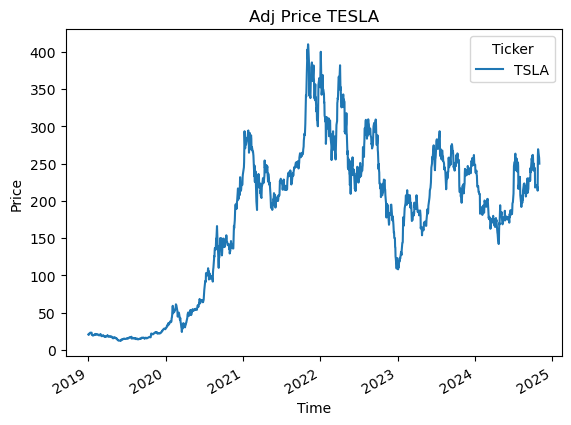

In [58]:
import matplotlib.pyplot as plt

data_adj = data['Adj Close'].dropna()

data_adj.plot(title='Adj Price TESLA', xlabel='Time', ylabel = 'Price')

- Para obtener mejores resultados debemos deshacernos de la estacionalidad,  del ruido y normalizar nuestras series de tiempo. Primero evaluamos tres maneras de eliminar la estacionalidad a partir del primedio de los residuales. Entre más alejado sea de 0, será el método que más nos convenga.

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

des_add = seasonal_decompose(data_adj, model='additive', period=365)
des_mult = seasonal_decompose(data_adj, model='multiplicative', period=365)
des_stl = STL(data_adj, period = 365).fit()

In [60]:
des_add.resid.mean(), des_mult.resid.mean(), des_stl.resid.mean()

(2.3010124391920863, 0.9670052173817174, 1.5954741079891235)

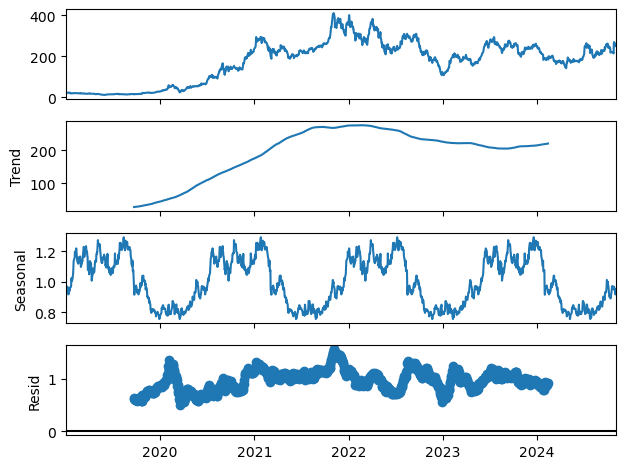

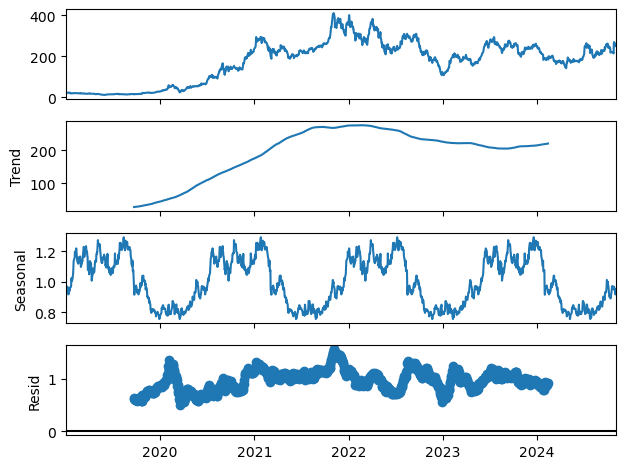

In [61]:
des_mult.plot()

- Una vez analizados los promedios residuales nos percatamos que el promedio más bajo es el de la descomposición multiplicativa, por lo que elegiremos este

In [62]:
estacionalidad = des_mult.seasonal

In [63]:
data_clean = data_adj['TSLA'] - estacionalidad

<Axes: xlabel='Date'>

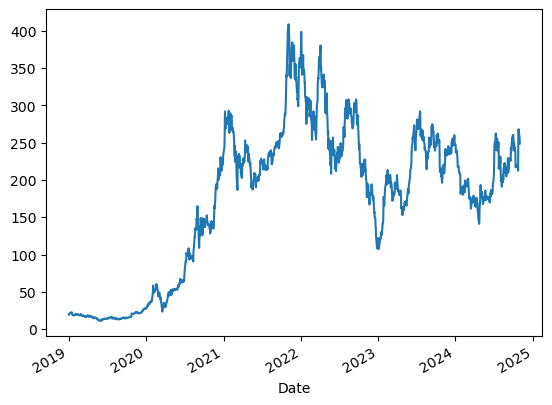

In [64]:
data_clean.plot()

<Axes: xlabel='Date'>

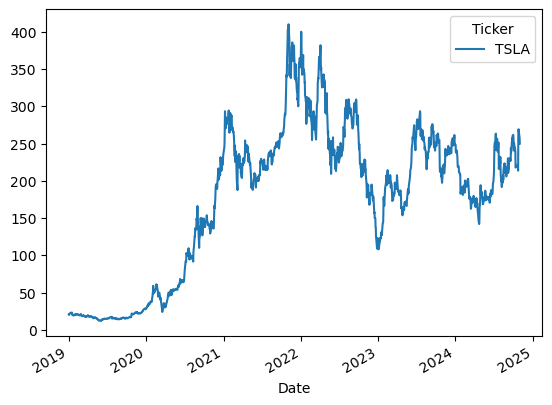

In [65]:
data_adj.plot()

In [66]:
df_process = data_clean.to_frame()

### 3. Pipeline

**Window Time**
$$t - w$$

**Window Time Predict**
$$t + 1$$

- Ventanas de predicción para pedirle al modelo que prediga el siguiente dato.

In [67]:
def window_time(dataset, lookback):

    X, y = [], [] #caraccterísticas y salidas objetivo
    for i in range(len(dataset)-lookback-1):
        feature = dataset[i:(i+lookback)] #ventana del tamaño del lookback
        target = dataset[i+lookback] #valor contiguo de la ventana actual
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y) #Ventana anterior X, ventana siguiente Y

- División y tratamiento de los datos de entrenamiento, prueba y validación

In [68]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

data_train = sc.fit_transform(data_adj) #normalización de los datos

lookback = 10
X, y = window_time(data_train, lookback)

In [69]:
train_size = int(len(data_train) * 0.67)
test_size = len(data_train) - train_size

X_data = torch.Tensor(X)
y_data = torch.Tensor(y)

X_train = torch.Tensor(X[0:train_size])
y_train = torch.Tensor(y[0:train_size])

X_test = torch.Tensor(X[train_size:len(X)])
y_test = torch.Tensor(y[train_size:len(y)])

In [70]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([984, 10, 1]),
 torch.Size([984, 1]),
 torch.Size([474, 10, 1]),
 torch.Size([474, 1]))

### 4. Modelo - Arquitectura LSTM

In [18]:
import torch.nn as nn
from torch import optim
import torch.utils.data

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):

        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, 
                        hidden_size=hidden_size, 
                        num_layers=num_layers, 
                        batch_first=True)
        self.fc1 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) #estado oculto inicial
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) #memoria inicial

        _, (h_out, _) = self.lstm(x, (h_0, c_0)) #recibe secuencia de entrada y estados iniciales 
        h_out = h_out.reshape(-1, self.hidden_size) #estado oculto final de la última capa que se aplana
        out = self.fc1(h_out) #transformaciones de dimensiones

        return out

### 5. Entrenamiento

In [21]:
model = LSTM(input_size=1, hidden_size=2, num_layers=1, num_classes=1)
loss_fn = nn.MSELoss()

In [22]:
def train(model, device, X_train, y_train, optimizer, epoch):

  model.train()
  X_train = X_train.to(device)
  y_train = y_train.to(device)

  outputs = model(X_train)
  optimizer.zero_grad()

  loss = loss_fn(outputs, y_train)

  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [24]:
model.to(device)

lstm_optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
epochs = 2000

for epoch in range(epochs):
    train(model, device, X_train, y_train, lstm_optimizer, epoch)

Epoch: 0, loss: 0.26163
Epoch: 100, loss: 0.10309
Epoch: 200, loss: 0.04186
Epoch: 300, loss: 0.00569
Epoch: 400, loss: 0.00252
Epoch: 500, loss: 0.00214
Epoch: 600, loss: 0.00195
Epoch: 700, loss: 0.00185
Epoch: 800, loss: 0.00177
Epoch: 900, loss: 0.00169
Epoch: 1000, loss: 0.00163
Epoch: 1100, loss: 0.00156
Epoch: 1200, loss: 0.00150
Epoch: 1300, loss: 0.00143
Epoch: 1400, loss: 0.00137
Epoch: 1500, loss: 0.00132
Epoch: 1600, loss: 0.00126
Epoch: 1700, loss: 0.00121
Epoch: 1800, loss: 0.00116
Epoch: 1900, loss: 0.00111


### 6. Evaluación del modelo

<function matplotlib.pyplot.show(close=None, block=None)>

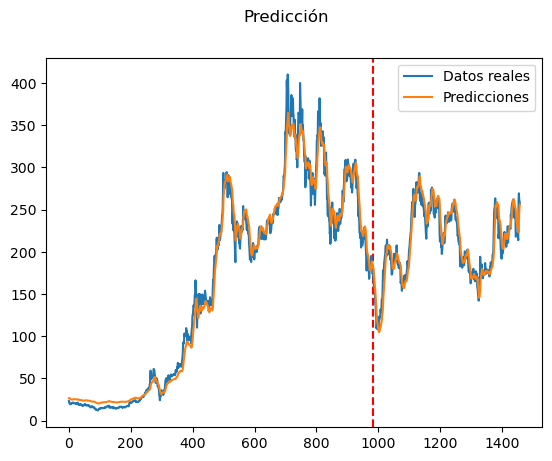

In [26]:
model.eval()

X_data = X_data.to(device)
train_predict = model(X_data)

data_predict = train_predict.data.cpu().numpy()
y_plot = y_data.data.numpy()

data_predict = sc.inverse_transform(data_predict)
y_plot = sc.inverse_transform(y_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(y_plot, label='Datos reales')
plt.plot(data_predict, label='Predicciones')
plt.suptitle('Predicción')
plt.legend()
plt.show

- Evaluación del modelo con un nuevo conjunto de datos (META)

In [27]:
data = yf.download('META', start='2019-01-01', end='2024-11-01', interval='1d')

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META,META
Date,,,,,,
2019-01-02 00:00:00+00:00,135.272705,135.679993,137.509995,128.559998,128.990005,28146200
2019-01-03 00:00:00+00:00,131.344528,131.740005,137.169998,131.119995,134.690002,22717900
2019-01-04 00:00:00+00:00,137.535889,137.949997,138.000000,133.750000,134.009995,29002100
2019-01-07 00:00:00+00:00,137.635590,138.050003,138.869995,135.910004,137.559998,20089300
2019-01-08 00:00:00+00:00,142.102158,142.529999,143.139999,139.539993,139.889999,26263800


<Axes: title={'center': 'Adj Price META'}, xlabel='Time', ylabel='Price'>

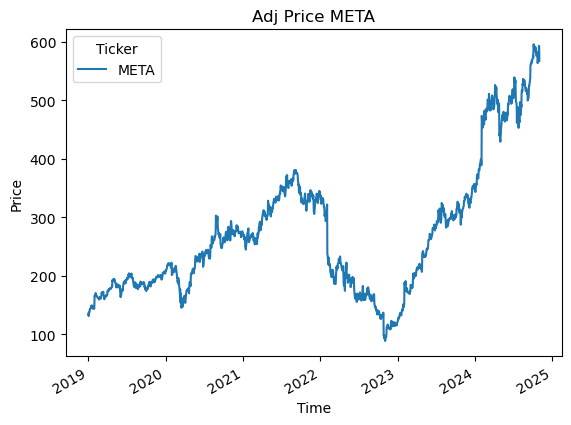

In [28]:
data_adj = data['Adj Close'].dropna()

data_adj.plot(title='Adj Price META', xlabel='Time', ylabel = 'Price')

In [29]:
data_train = sc.fit_transform(data_adj)

lookback = 10
X, y = window_time(data_train, lookback)

In [30]:
X_data = torch.Tensor(X)
y_data = torch.Tensor(y)

<function matplotlib.pyplot.show(close=None, block=None)>

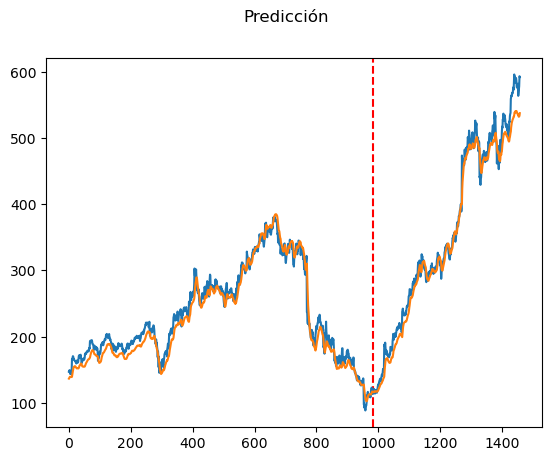

In [31]:
model.eval()

X_data = X_data.to(device)
train_predict = model(X_data)

data_predict = train_predict.data.cpu().numpy()
y_plot = y_data.data.numpy()

data_predict = sc.inverse_transform(data_predict)
y_plot = sc.inverse_transform(y_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(y_plot)
plt.plot(data_predict)
plt.suptitle('Predicción')
plt.show

### 7. Predicción

- Se predice los siguientes 365 días de la acción de Tesla.

<Axes: xlabel='Date'>

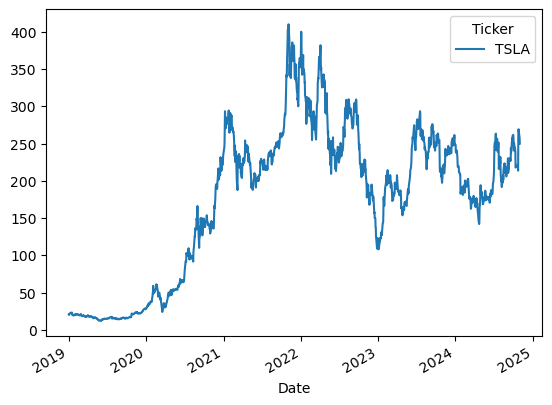

In [71]:
data_adj.plot()

In [72]:
X_data[-1:]

tensor([[[0.5261],
         [0.5250],
         [0.5245],
         [0.5198],
         [0.5176],
         [0.5068],
         [0.6244],
         [0.6463],
         [0.6295],
         [0.6220]]])

In [73]:
X_data = X_data[-1:] #última ventana del conjunto de datos

X_data_ult = X_data.to(device)

In [74]:
X_data_ult.shape

torch.Size([1, 10, 1])

In [75]:
model.eval()

prediction = []


for _ in range(365):
    with torch.no_grad():

        print(X_data_ult.shape)
        output = model(X_data_ult)

        prediction.append(output.item())

        new_input = output.unsqueeze(0)

        X_data_ult = torch.cat([X_data_ult[:, 1:, :], new_input], dim=1)



torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size([1, 10, 1])
torch.Size(

In [76]:
prediction

[0.6129278540611267,
 0.6179893612861633,
 0.6234403848648071,
 0.6289771199226379,
 0.6345850229263306,
 0.6401696801185608,
 0.6457828283309937,
 0.6497030854225159,
 0.6532741189002991,
 0.6570515632629395,
 0.6609139442443848,
 0.6648621559143066,
 0.6686959266662598,
 0.6723992228507996,
 0.6759660243988037,
 0.6793923377990723,
 0.6826763153076172,
 0.6858168840408325,
 0.6888334155082703,
 0.6917291879653931,
 0.6945009231567383,
 0.6971473097801208,
 0.6996676325798035,
 0.7020640969276428,
 0.7043393850326538,
 0.7064967155456543,
 0.7085395455360413,
 0.7104716300964355,
 0.7122968435287476,
 0.7140190601348877,
 0.7156422138214111,
 0.7171703577041626,
 0.718607485294342,
 0.7199578285217285,
 0.7212255001068115,
 0.7224146127700806,
 0.7235291004180908,
 0.7245728969573975,
 0.7255498170852661,
 0.7264635562896729,
 0.7273176312446594,
 0.7281154990196228,
 0.7288604974746704,
 0.7295557260513306,
 0.7302042245864868,
 0.7308089137077332,
 0.7313724756240845,
 0.73189747333

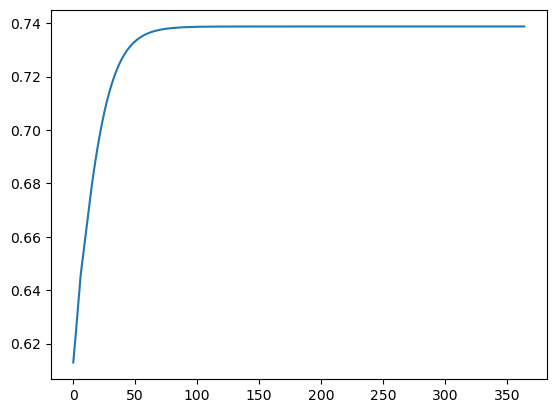

In [77]:
plt.plot(prediction)